# Plot Malignancy Estimation Results

Code adapted from the following repositories:

* [Kiran model](https://github.com/DIAGNijmegen/bodyct-nodule-malignancy)
* [Thijmen model](https://github.com/DIAGNijmegen/bodyct-lung-malignancy)
* [StackOverflow on right-align legend text](https://stackoverflow.com/questions/7936034/text-alignment-in-a-matplotlib-legend)

In [1]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

%matplotlib inline
import sklearn.metrics as skl_metrics

import utils
from utils import plot_rocs

## Read Data (DLCST results)

In [2]:
## directory where results are
LOCAL_PC = False
root_dir = "/mnt/w" if LOCAL_PC else ""
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
DLCST_PREDS = f"{EXPERIMENT_DIR}/dlcst"

DLCST_PREDS_LOCAL = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/dlcst"
DLCST_PREDS = DLCST_PREDS_LOCAL ## Comment out if not using Teams backup (aka Chansey is up :)

In [3]:
## Read DLCST results
df_results = pd.read_csv(f"{DLCST_PREDS}/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
df_results.head()

,PatientID,StudyDate,SeriesInstanceUID,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
0,4,20050124,1.2.840.113704.1.111.4964.1106577805.10,55,2,0,0,9,0.021629,0.038573,0.071919,0.079270,0.095846,0.135681,0.053366,0.082652,0.166209,0
1,35,20051208,1.2.840.113704.1.111.5776.1134059140.11,56,1,1,1,2,0.001170,0.002554,0.007835,0.011039,0.018442,0.030460,0.009543,0.000408,0.003368,0
2,38,20060109,1.2.840.113704.1.111.2004.1136823831.14,62,2,0,1,4,0.001784,0.003870,0.007835,0.012797,0.019229,0.032957,0.006734,0.002702,0.065888,0
3,47,20051214,1.2.840.113704.1.111.8148.1134579622.14,57,1,0,1,1,0.003951,0.015674,0.025373,0.034010,0.040605,0.058852,0.007944,0.084158,0.423341,0
4,56,20051213,1.2.840.113704.1.111.2744.1134487263.11,64,1,0,1,3,0.000000,0.001574,0.003791,0.006847,0.010381,0.017287,0.000899,0.000013,0.005590,0


In [4]:
len(pd.unique(df_results['SeriesInstanceUID'])), len(pd.unique(df_results['PatientID']))

(599, 599)

In [5]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [6]:
df_results.describe()

,PatientID,StudyDate,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
count,599.000000,5.990000e+02,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,5.990000e+02,599.000000,599.000000
mean,1883.756260,2.005100e+07,58.397329,1.460768,0.170284,0.676127,1.769616,0.025965,0.040542,0.050433,0.058651,0.067412,0.089968,0.055902,1.461987e-01,0.166094,0.098497
std,1215.815006,7.593265e+03,4.946103,0.498875,0.376196,0.468343,1.165421,0.080576,0.104781,0.111505,0.115754,0.121409,0.135617,0.118722,2.966031e-01,0.241460,0.298235
min,4.000000,2.004111e+07,50.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.820000e-07,0.000574,0.000000
25%,800.500000,2.005013e+07,54.000000,1.000000,0.000000,0.000000,1.000000,0.001170,0.002554,0.007835,0.012797,0.019229,0.032957,0.002396,2.369950e-04,0.011600,0.000000
50%,1689.000000,2.005052e+07,58.000000,1.000000,0.000000,1.000000,1.000000,0.001965,0.005733,0.010996,0.015721,0.021112,0.035951,0.007804,2.825316e-03,0.045436,0.000000
75%,3011.500000,2.005103e+07,62.000000,2.000000,0.000000,1.000000,2.000000,0.007145,0.020146,0.029786,0.039906,0.051451,0.076318,0.044897,6.282042e-02,0.201205,0.000000
max,4099.000000,2.009122e+07,75.000000,2.000000,1.000000,1.000000,9.000000,0.838213,0.903660,0.902390,0.914693,0.914693,0.914693,0.789437,9.988375e-01,0.977596,1.000000


<Axes: xlabel='Age', ylabel='Count'>

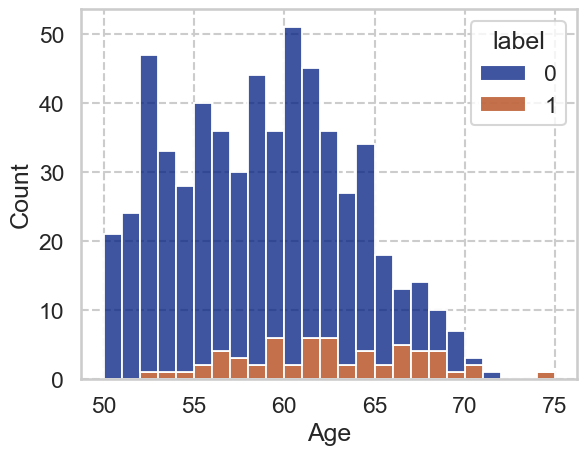

In [7]:
sns.histplot(df_results, x="Age", bins=25, hue="label", multiple='stack')

In [8]:
df_results.query('Age == 70')['label'].value_counts()

label
1    2
0    1
Name: count, dtype: int64

In [9]:
df_malignant = df_results.query('label == 1')
df_malignant.describe()

,PatientID,StudyDate,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
count,59.000000,5.900000e+01,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0
mean,2226.067797,2.006203e+07,62.000000,1.457627,0.271186,0.745763,1.711864,0.145046,0.200687,0.222831,0.240233,0.258463,0.307859,0.221539,0.698916,0.616382,1.0
std,1146.619783,1.472711e+04,4.856563,0.502478,0.448388,0.439169,1.175187,0.179729,0.218469,0.226036,0.228718,0.236872,0.248971,0.201549,0.336146,0.273137,0.0
min,62.000000,2.004112e+07,52.000000,1.000000,0.000000,0.000000,1.000000,0.000421,0.002048,0.006331,0.010185,0.014170,0.022664,0.003140,0.000115,0.007771,1.0
25%,1303.500000,2.005072e+07,59.000000,1.000000,0.000000,0.500000,1.000000,0.010938,0.023848,0.040202,0.056078,0.068311,0.104660,0.050493,0.528134,0.474855,1.0
50%,2218.000000,2.005121e+07,62.000000,1.000000,0.000000,1.000000,1.000000,0.084456,0.143517,0.172521,0.197799,0.211975,0.276596,0.167578,0.833620,0.678868,1.0
75%,3300.500000,2.007056e+07,66.000000,2.000000,1.000000,1.000000,2.000000,0.215565,0.306710,0.306925,0.337119,0.365862,0.415215,0.296643,0.971705,0.837449,1.0
max,4032.000000,2.009122e+07,75.000000,2.000000,1.000000,1.000000,7.000000,0.838213,0.903660,0.902390,0.914693,0.914693,0.914693,0.789437,0.998838,0.977596,1.0


### Define DLCST Splits
DataFrame queries for subsets. Can use this for plots and whatnot.

In [10]:
SPLIT_QUERIES = {
    "sex": {
        "male": 'Sex == 1',
        "female": 'Sex == 2' 
    },
    "family history": {
        "no": 'FamilyHistoryLungCa == 0',
        "yes": 'FamilyHistoryLungCa == 1' 
    },
    "emphysema": {
        "no": 'Emphysema == 0',
        "yes": 'Emphysema == 1' 
    },
    "age": {
        "50-62": '50 <= Age < 62',
        "62+": '62 <= Age', 
    },
    "nodule count": {
        "1": 'NoduleCountPerScan == 1',
        ">1": 'NoduleCountPerScan > 1' 
    }
}

In [11]:
def get_split_dfs(df, split_by="sex", printinfo=True):
    subset_dfs = {}
    for (split, query) in SPLIT_QUERIES[split_by].items():
        subset_dfs[split] = df.query(query)
        
        if printinfo:
            mal_count = len(subset_dfs[split].query('label == 1'))
            mal_percent = 100 * (mal_count / len(subset_dfs[split]))
            print(f"{split}, n={len(subset_dfs[split])}, {mal_count} malignant ({mal_percent:.2f}%)")
    
    return subset_dfs

## ROC Plots

### Compare ROCs across models

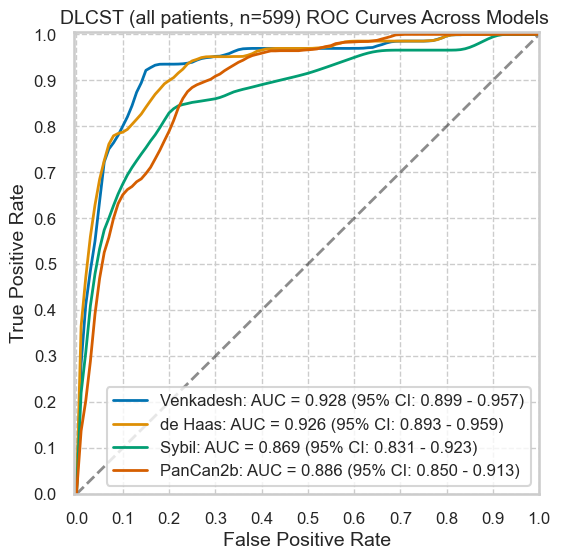

In [12]:
MODEL_TO_COL = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

def rocs_models(df, true_col='label', models=["Venkadesh", "de Haas", "Sybil", "PanCan2b"], dataset_label="DLCST", subset_label="all", imgpath=None, plot_ci=False):
    rocs = {}
    for m in models:
        rocs[m] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[m]].values, df[true_col].values)
    
    plot_rocs(rocs, f'{dataset_label} ({subset_label} patients, n={len(df)}) ROC Curves Across Models ', imgpath, plot_ci)

rocs_models(df_results)

### Plot Splits for Same Model

In [14]:
def rocs_splits(df, cat="sex", dataset_label="DLCST", true_col='label', models=MODEL_TO_COL, imgpath=None, plot_ci=False):
    groups = get_split_dfs(df, cat, printinfo=False).items()

    df_catinfo, skips = utils.info_by_splits(groups, 2)
    display(df_catinfo)
    # plot_roc = (0 not in df_catinfo['num_mal']) and (len() not in df_catinfo['pct_mal'])

    rocs = {}
    for m in models:
        rocs[m], df_perf = utils.perf_by_splits(groups, pred_col=MODEL_TO_COL[m])
        print(m)
        display(df_perf)

    do_sigtest = (len(df_catinfo) - len(skips)) == 2
    bin_sigtest_results = {}

    fig, ax = plt.subplots(1, len(models), figsize=(6.5 * len(models) - 0.5, 6.5))
    fig.suptitle(f"Model Performance Split By {cat}")
    for i, m in enumerate(models):
        title_str = m
        if do_sigtest:
            z, p = utils.hanley_mcneil_sigtest(df_catinfo, skips, rocs[m])
            title_str = f"{m}\n(z={z:.6f}, p={p:.6f})"
            bin_sigtest_results[m] = {"z": z, "p": p}

        utils.ax_rocs(ax[i], rocs[m], title=title_str)
    plt.show()

    df_sigtest_results = None
    if do_sigtest:
        df_sigtest_results = pd.DataFrame(bin_sigtest_results)
    
    display(df_sigtest_results)

    return df_sigtest_results

    # rocs = {}
    # rocs['all'] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[model]].values, df[true_col].values)   
    # for split, df_subset in subset_dfs.items():
    #     rocs[split] = get_bootstrapped_roc_ci_curves(df_subset[MODEL_TO_COL[model]].values, df_subset[true_col].values)
    
    # plot_rocs(rocs, f'{dataset_label} (split by {split_by}) ROC Curves for {model} Model', imgpath, plot_ci)

,num,pct,num_mal,pct_mal
male,323,53.923205,32,9.907121
female,276,46.076795,27,9.782609


Venkadesh


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,28,40,251,4,0.875,0.137457,0.125,0.862543,0.411765,0.984314,0.588235,0.015686,0.863777,0.737543,0.560000,0.540486
female,276,27,56,193,0,1.000,0.224900,0.000,0.775100,0.325301,1.000000,0.674699,0.000000,0.797101,0.775100,0.490909,0.502137


de Haas


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,30,104,187,2,0.9375,0.357388,0.0625,0.642612,0.223881,0.989418,0.776119,0.010582,0.671827,0.580112,0.361446,0.351763
female,276,27,108,141,0,1.0000,0.433735,0.0000,0.566265,0.200000,1.000000,0.800000,0.000000,0.608696,0.566265,0.333333,0.336531


Sybil


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,18,15,276,14,0.562500,0.051546,0.437500,0.948454,0.545455,0.951724,0.454545,0.048276,0.910217,0.510954,0.553846,0.504019
female,276,13,11,238,14,0.481481,0.044177,0.518519,0.955823,0.541667,0.944444,0.458333,0.055556,0.909420,0.437305,0.509804,0.461063


PanCan2b


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
male,323,22,31,260,10,0.687500,0.106529,0.312500,0.893471,0.415094,0.962963,0.584906,0.037037,0.873065,0.580971,0.517647,0.468658
female,276,19,51,198,8,0.703704,0.204819,0.296296,0.795181,0.271429,0.961165,0.728571,0.038835,0.786232,0.498884,0.391753,0.340643


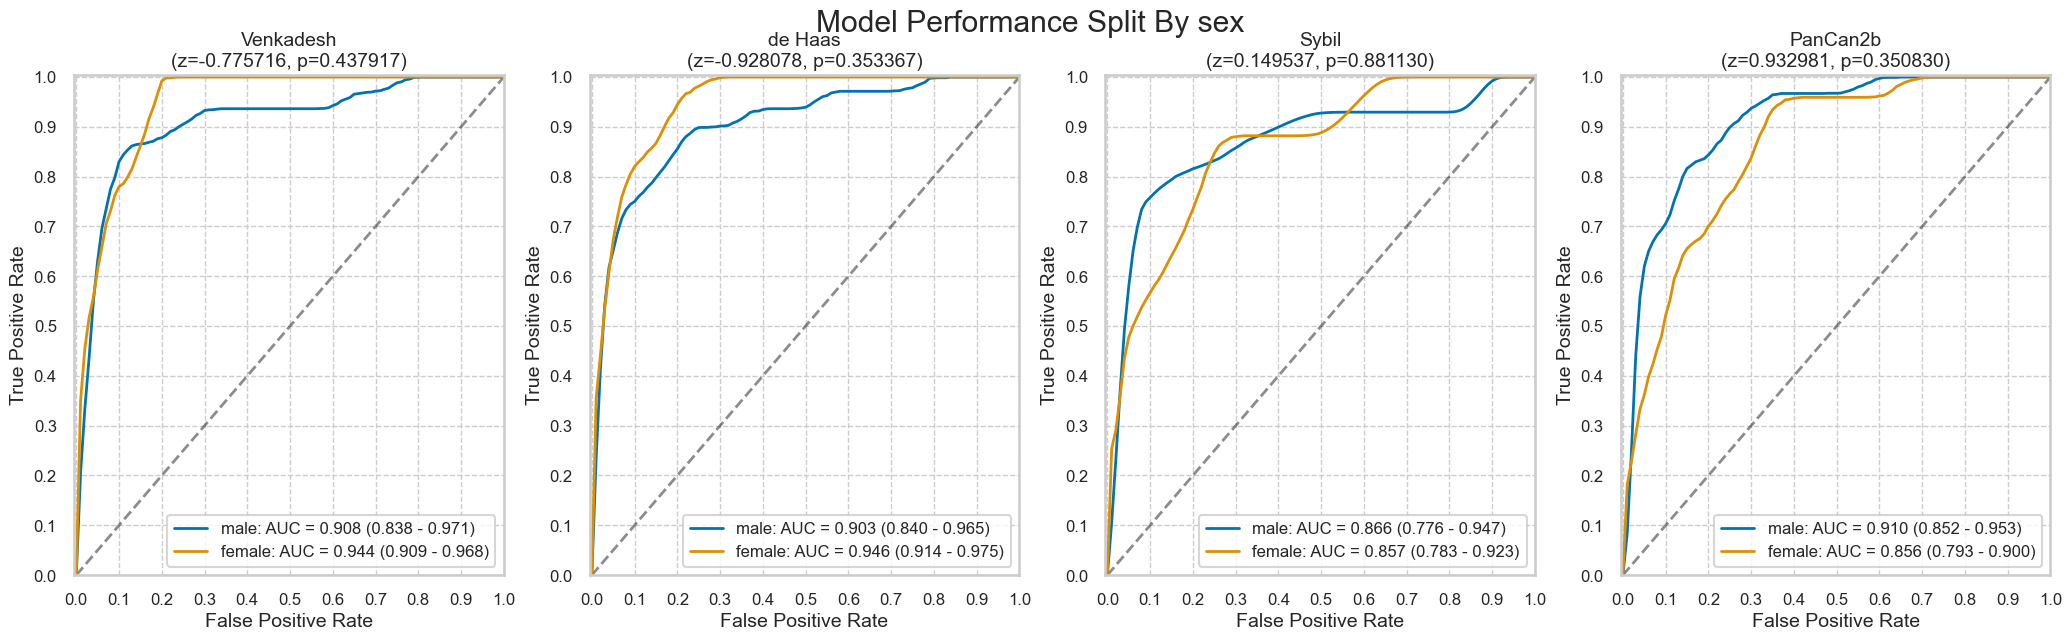

,Venkadesh,de Haas,Sybil,PanCan2b
z,-0.775716,-0.928078,0.149537,0.932981
p,0.437917,0.353367,0.881130,0.350830


,num,pct,num_mal,pct_mal
no,497,82.971619,43,8.651911
yes,102,17.028381,16,15.686275


Venkadesh


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,497,39,80,374,4,0.906977,0.176211,0.093023,0.823789,0.327731,0.989418,0.672269,0.010582,0.830986,0.730765,0.481481,0.481416
yes,102,16,16,70,0,1.000000,0.186047,0.000000,0.813953,0.500000,1.000000,0.500000,0.000000,0.843137,0.813953,0.666667,0.637947


de Haas


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,497,41,177,277,2,0.953488,0.389868,0.046512,0.610132,0.188073,0.992832,0.811927,0.007168,0.639839,0.563621,0.314176,0.319314
yes,102,16,35,51,0,1.000000,0.406977,0.000000,0.593023,0.313725,1.000000,0.686275,0.000000,0.656863,0.593023,0.477612,0.431331


Sybil


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,497,23,21,433,20,0.534884,0.046256,0.465116,0.953744,0.522727,0.955850,0.477273,0.044150,0.917505,0.488628,0.528736,0.483577
yes,102,8,5,81,8,0.500000,0.058140,0.500000,0.941860,0.615385,0.910112,0.384615,0.089888,0.872549,0.441860,0.551724,0.481868


PanCan2b


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,497,28,66,388,15,0.651163,0.145374,0.348837,0.854626,0.297872,0.962779,0.702128,0.037221,0.837022,0.505788,0.408759,0.363090
yes,102,13,16,70,3,0.812500,0.186047,0.187500,0.813953,0.448276,0.958904,0.551724,0.041096,0.813725,0.626453,0.577778,0.505054


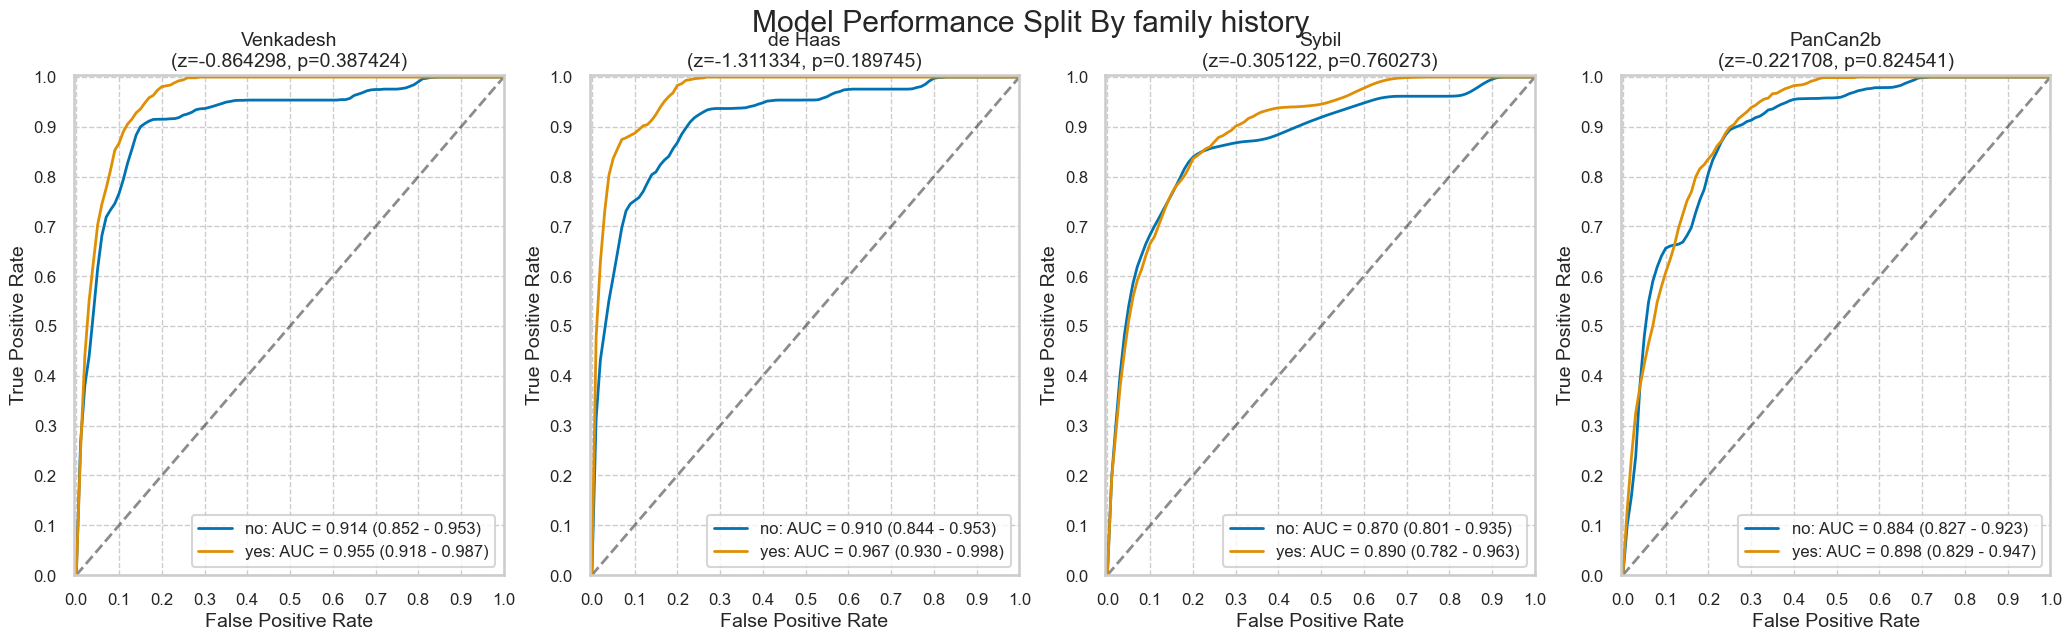

,Venkadesh,de Haas,Sybil,PanCan2b
z,-0.864298,-1.311334,-0.305122,-0.221708
p,0.387424,0.189745,0.760273,0.824541


,num,pct,num_mal,pct_mal
no,194,32.387312,15,7.731959
yes,405,67.612688,44,10.864198


Venkadesh


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,194,15,22,157,0,1.000000,0.122905,0.000000,0.877095,0.405405,1.000000,0.594595,0.000000,0.886598,0.877095,0.576923,0.596304
yes,405,40,74,287,4,0.909091,0.204986,0.090909,0.795014,0.350877,0.986254,0.649123,0.013746,0.807407,0.704105,0.506329,0.487212


de Haas


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,194,15,56,123,0,1.000000,0.312849,0.000000,0.687151,0.211268,1.000000,0.788732,0.000000,0.711340,0.687151,0.348837,0.381015
yes,405,42,156,205,2,0.954545,0.432133,0.045455,0.567867,0.212121,0.990338,0.787879,0.009662,0.609877,0.522412,0.347107,0.325219


Sybil


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,194,7,5,174,8,0.466667,0.027933,0.533333,0.972067,0.583333,0.956044,0.416667,0.043956,0.932990,0.438734,0.518519,0.486460
yes,405,24,21,340,20,0.545455,0.058172,0.454545,0.941828,0.533333,0.944444,0.466667,0.055556,0.898765,0.487283,0.539326,0.482507


PanCan2b


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
no,194,9,15,164,6,0.600000,0.083799,0.400000,0.916201,0.375000,0.964706,0.625000,0.035294,0.891753,0.516201,0.461538,0.418756
yes,405,32,67,294,12,0.727273,0.185596,0.272727,0.814404,0.323232,0.960784,0.676768,0.039216,0.804938,0.541677,0.447552,0.392231


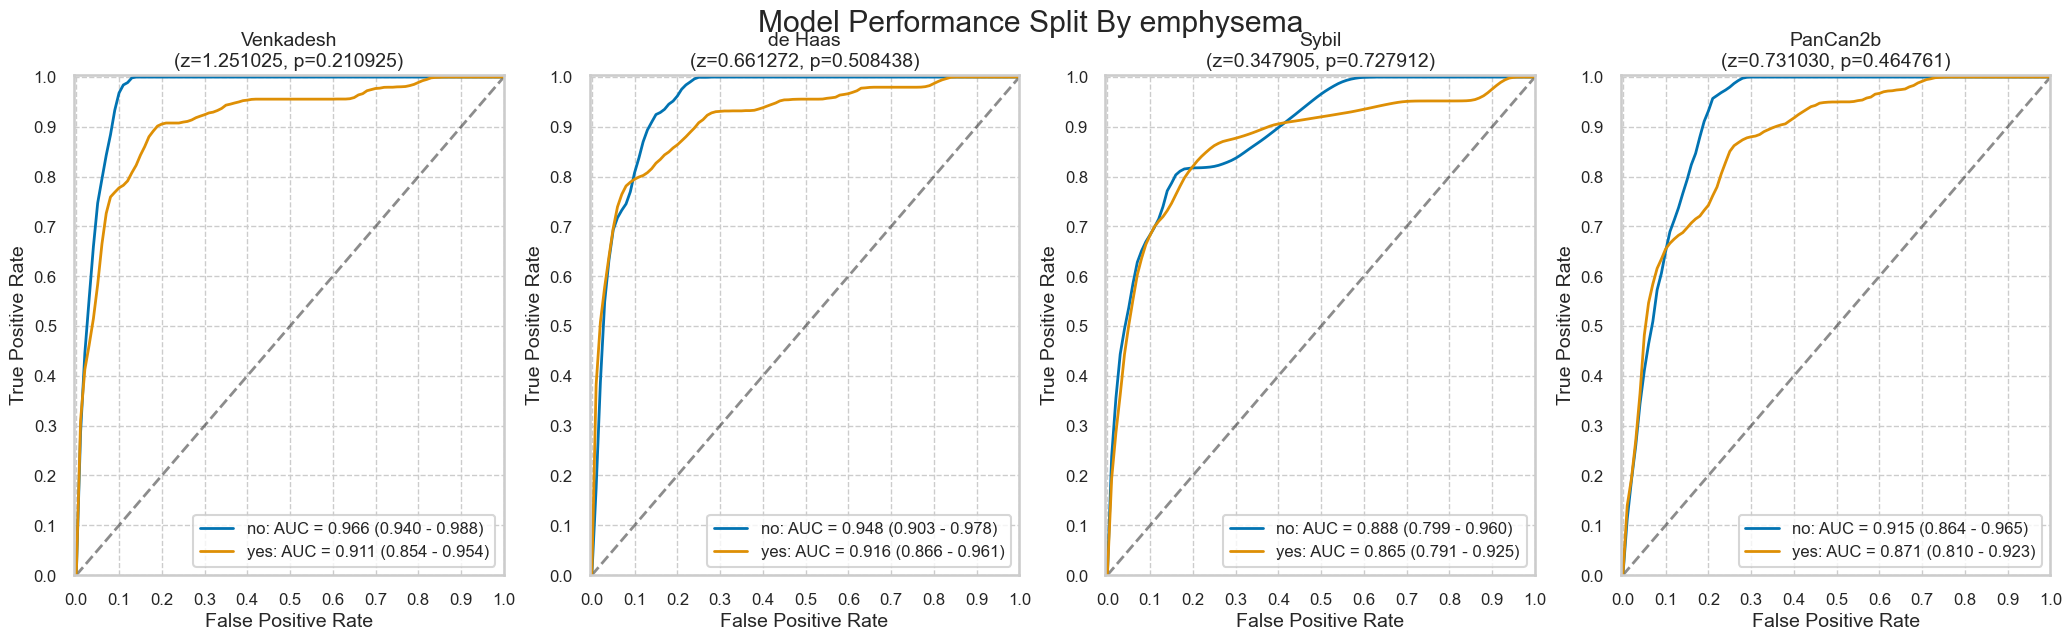

,Venkadesh,de Haas,Sybil,PanCan2b
z,1.251025,0.661272,0.347905,0.731030
p,0.210925,0.508438,0.727912,0.464761


,num,pct,num_mal,pct_mal
50-62,435,72.621035,28,6.436782
62+,164,27.378965,31,18.902439


Venkadesh


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
50-62,435,26,71,336,2,0.928571,0.174447,0.071429,0.825553,0.268041,0.994083,0.731959,0.005917,0.832184,0.754124,0.416000,0.444606
62+,164,29,25,108,2,0.935484,0.187970,0.064516,0.812030,0.537037,0.981818,0.462963,0.018182,0.835366,0.747514,0.682353,0.622777


de Haas


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
50-62,435,27,154,253,1,0.964286,0.378378,0.035714,0.621622,0.149171,0.996063,0.850829,0.003937,0.643678,0.585907,0.258373,0.291708
62+,164,30,58,75,1,0.967742,0.436090,0.032258,0.563910,0.340909,0.986842,0.659091,0.013158,0.640244,0.531652,0.504202,0.417432


Sybil


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
50-62,435,11,17,390,17,0.392857,0.041769,0.607143,0.958231,0.392857,0.958231,0.607143,0.041769,0.921839,0.351088,0.392857,0.351088
62+,164,20,9,124,11,0.645161,0.067669,0.354839,0.932331,0.689655,0.918519,0.310345,0.081481,0.878049,0.577492,0.666667,0.592634


PanCan2b


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
50-62,435,19,55,352,9,0.678571,0.135135,0.321429,0.864865,0.256757,0.975069,0.743243,0.024931,0.852874,0.543436,0.372549,0.354940
62+,164,22,27,106,9,0.709677,0.203008,0.290323,0.796992,0.448980,0.921739,0.551020,0.078261,0.780488,0.506670,0.550000,0.433396


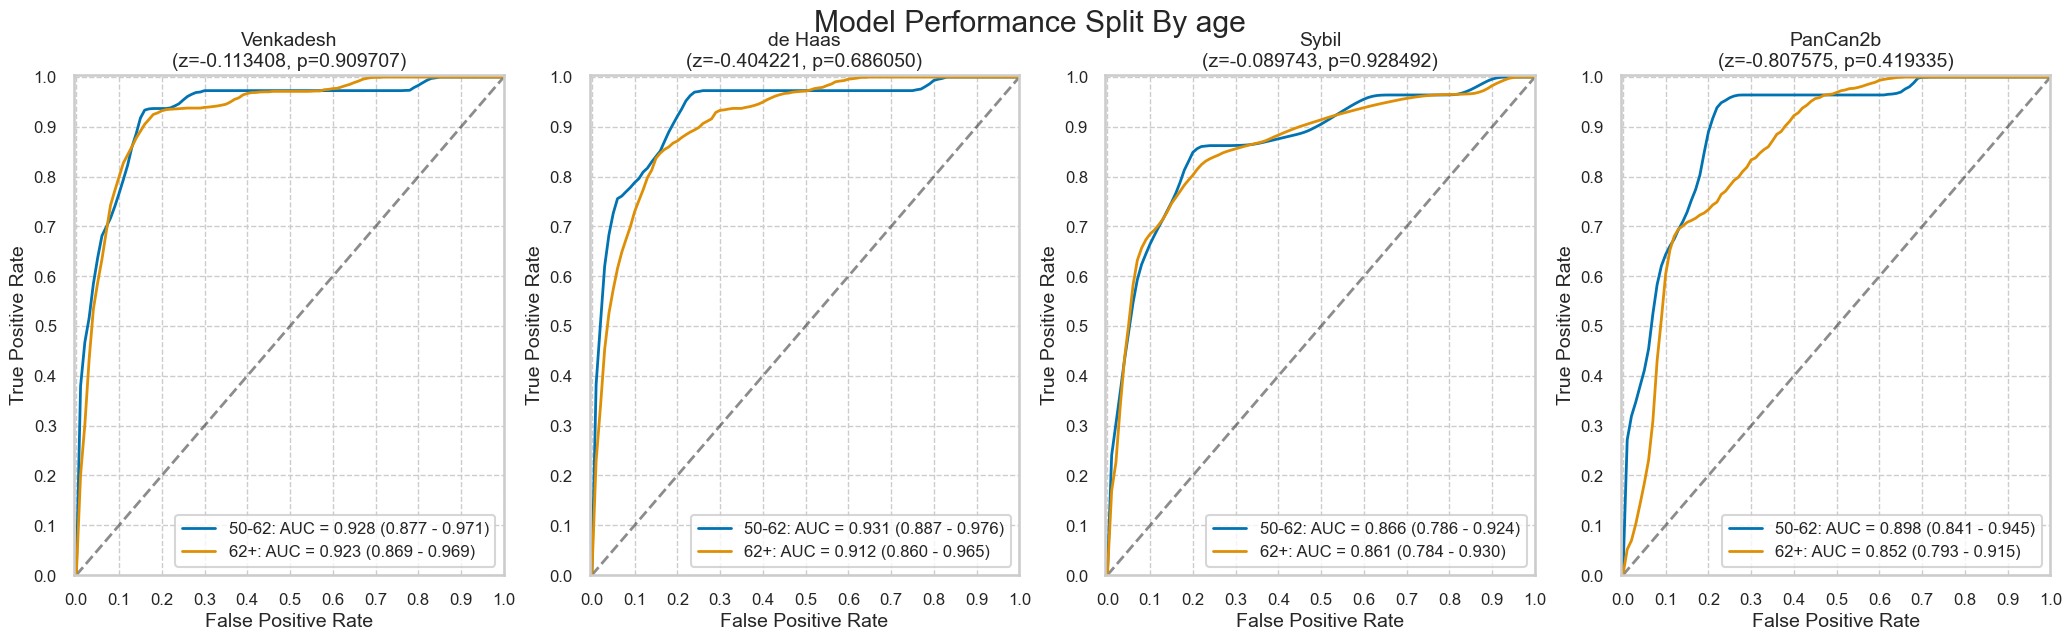

,Venkadesh,de Haas,Sybil,PanCan2b
z,-0.113408,-0.404221,-0.089743,-0.807575
p,0.909707,0.686050,0.928492,0.419335


,num,pct,num_mal,pct_mal
1,333,55.592654,35,10.510511
>1,266,44.407346,24,9.022556


Venkadesh


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
1,333,32,47,251,3,0.914286,0.157718,0.085714,0.842282,0.405063,0.988189,0.594937,0.011811,0.84985,0.756568,0.561404,0.545456
>1,266,23,49,193,1,0.958333,0.202479,0.041667,0.797521,0.319444,0.994845,0.680556,0.005155,0.81203,0.755854,0.479167,0.487398


de Haas


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
1,333,33,112,186,2,0.942857,0.375839,0.057143,0.624161,0.227586,0.989362,0.772414,0.010638,0.657658,0.567018,0.366667,0.350733
>1,266,24,100,142,0,1.000000,0.413223,0.000000,0.586777,0.193548,1.000000,0.806452,0.000000,0.624060,0.586777,0.324324,0.337001


Sybil


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
1,333,22,11,287,13,0.628571,0.036913,0.371429,0.963087,0.666667,0.956667,0.333333,0.043333,0.927928,0.591659,0.647059,0.607290
>1,266,9,15,227,15,0.375000,0.061983,0.625000,0.938017,0.375000,0.938017,0.625000,0.061983,0.887218,0.313017,0.375000,0.313017


PanCan2b


,num,tp,fp,tn,fn,tpr,fpr,fnr,tnr,ppv,npv,fdr,for,acc,j,f1,mcc
1,333,25,44,254,10,0.714286,0.147651,0.285714,0.852349,0.362319,0.962121,0.637681,0.037879,0.837838,0.566635,0.480769,0.428764
>1,266,16,38,204,8,0.666667,0.157025,0.333333,0.842975,0.296296,0.962264,0.703704,0.037736,0.827068,0.509642,0.410256,0.363006


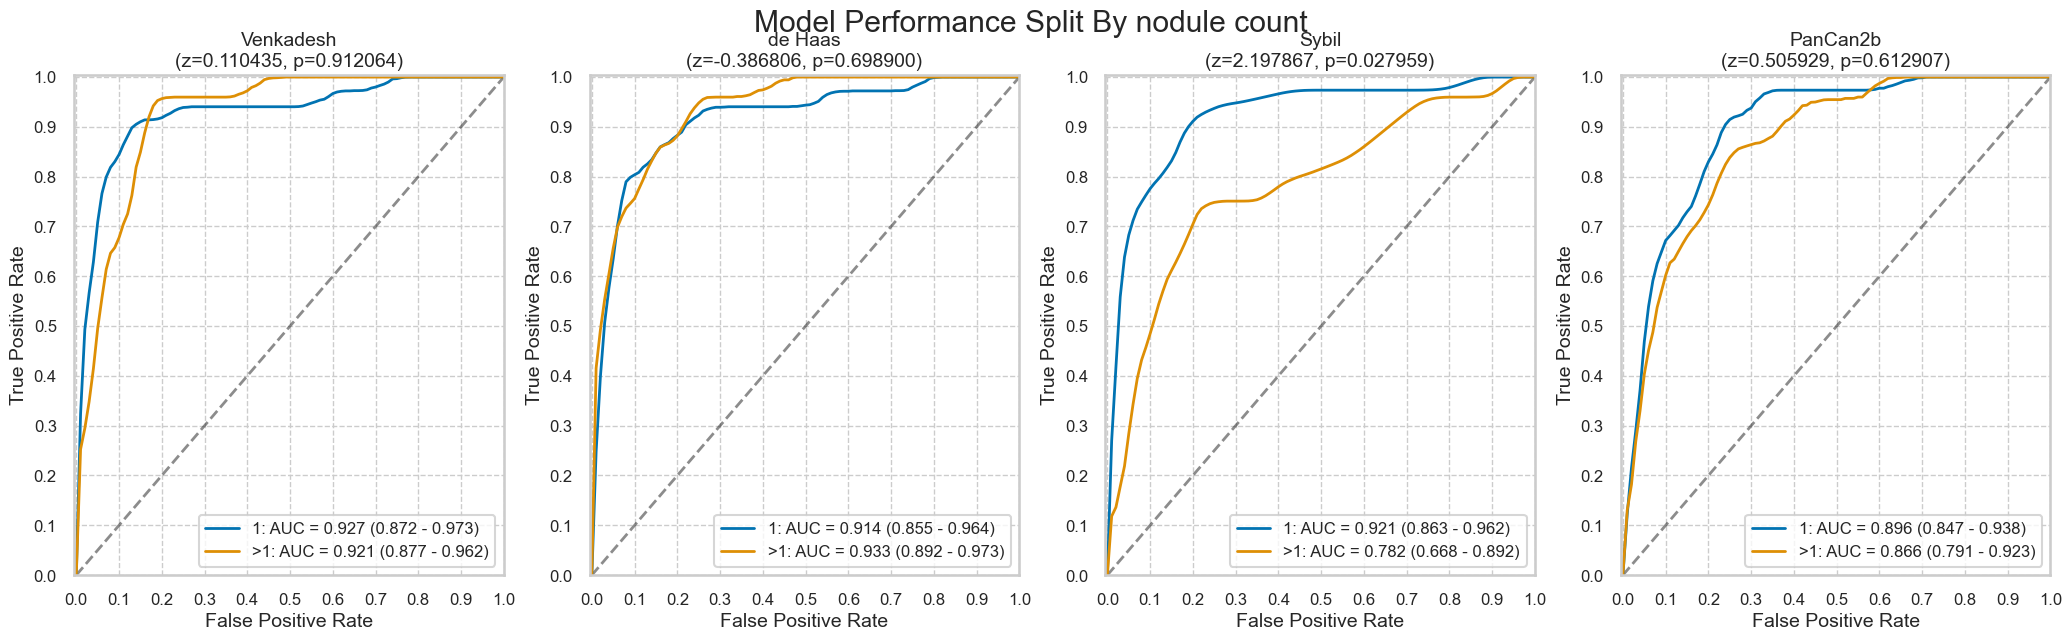

,Venkadesh,de Haas,Sybil,PanCan2b
z,0.110435,-0.386806,2.197867,0.505929
p,0.912064,0.698900,0.027959,0.612907


In [15]:
for q in SPLIT_QUERIES:
    rocs_splits(df_results, q)